# Classification Systems
In this practical, you are asked to compare the prediction error of:

- The Naive Bayes Classifier
- LDA.
- QDA.
- Nearest Shrunken Centroids Classifier.


In [2]:
import numpy as np
from scipy import linalg
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import colors
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
from sklearn.neighbors import NearestCentroid
import pandas as pd
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
import scipy as sp
from sklearn.naive_bayes import GaussianNB
matplotlib.rc('figure', figsize=(15, 5))
import warnings
warnings.filterwarnings('ignore')

## Loading the Data

We load both datasets from csv

In [1]:
import pandas as pd
df_1 = pd.read_json('prueba_v7_1_json_for_pandas.json')
aer = pd.read_csv('AER.tsv', sep='\t')


In [2]:
columns = [item.replace('+', 'plus') for item in df_1.columns.values]
columns = [item.replace('-', '_') for item in columns]
df_1.columns = columns

In [3]:
df_1 = df_1[df_1['FILTER_2']==1]
#df_1['INTERNALLY_IDENTIFIED'] = df_1['INTERNALLY_IDENTIFIED'].fillna('False')
df_1 = df_1[df_1['ref'] != '']
df_1 = df_1[df_1['ref'].notnull()]
"""df = df_1.drop(columns=['MutationTaster_AAE','MutPred_Top5features',
                      'MutPred_AAchange','SiPhy_29way_pi', 'CANONICAL',
                      'CADD_phred_hg19','CADD_raw_hg19', 'CADD_raw_rankscore_hg19',
                      'Mastermind_MMID3', 'genename', 'Ensembl_geneid',
                      'clinvar_hgvs', 'ENSP','Feature', 'SEQQ',
                      'Mastermind_counts', 'HGVSc', 'HGVSp','Ensembl_proteinid',
                      'Ensembl_transcriptid', 'Codons', 'Existing_variation', 'MANE_SELECT',
                      'gnomAD_NFE_AF','HGVSc_ANNOVAR','HGVSc_VEP', 'HGVSc_snpEff',
                      'HGVSp_ANNOVAR', 'HGVSp_VEP', 'HGVSp_snpEff','hg19_chr', 'rs_dbSNP"'])"""

df = df_1.loc[:,['COSMIC_N_MATCH', 'STRANDQ', 'POPAF', 'TLOD', 'STRAND', 'TSL', 'LoFtool',
 'BayesDel_noAF_score', 'ClinPred_score', 'DANN_rankscore',
 'Eigen_PC_phred_coding', 'Eigen_phred_coding', 'GERPplusplus_NR',
 'MetaLR_rankscore', 'MetaSVM_rankscore', 'MutationAssessor_rankscore',
 'MutationAssessor_score', 'Polyphen2_HVAR_rankscore', 'codon_degeneracy',
 'phastCons100way_vertebrate', 'phastCons17way_primate',
 'phastCons17way_primate_rankscore',
 'INTERNALLY_IDENTIFIED', 'PREVIOUSLY_IDENTIFIED', 'ARTIFACTS', 'variantInternalId', 'LONGITUDINAL_BOTH']]

"""df = df_1.loc[:,['STRANDQ',
 'fathmm_MKL_coding_rankscore',
 'Reliability_index',
 'SIFT4G_converted_rankscore',
 'POPAF',
 'Polyphen2_HVAR_rankscore',
 'STRAND',
 'GERPplusplus_NR',
 'POLYPHEN_SCORE',
 'Polyphen2_HDIV_score',
 'BayesDel_noAF_score',
 'BayesDel_addAF_score',
 'phyloP30way_mammalian',
 'SIFT_converted_rankscore',
 'MPOS',
 'INTERNALLY_IDENTIFIED', 'PREVIOUSLY_IDENTIFIED', 'ARTIFACTS', 'variantInternalId', 'LONGITUDINAL_BOTH']]"""
#df = df.drop(columns=['MutationTaster_AAE','MutPred_Top5features', 'MutPred_AAchange','SiPhy_29way_pi', 'CANONICAL', 'CADD_phred_hg19','CADD_raw_hg19', 'CADD_raw_rankscore_hg19', 'Mastermind_MMID3', 'genename', 'Ensembl_geneid', 'clinvar_hgvs', 'ENSP','Feature', 'SEQQ', 'Uniprot_acc', 'Mastermind_counts', 'HGVSc', 'HGVSp','Ensembl_proteinid', 'Ensembl_transcriptid', 'Codons', 'Existing_variation', 'MANE_SELECT', 'gnomAD_NFE_AF','HGVSc_ANNOVAR','HGVSc_VEP', 'HGVSc_snpEff', 'HGVSp_ANNOVAR', 'HGVSp_VEP', 'HGVSp_snpEff','hg19_chr', 'rs_dbSNP"'])
df['INTERNALLY_IDENTIFIED'] = df['INTERNALLY_IDENTIFIED'].fillna(0)
#df['EXON'] = df['EXON'].map(lambda x: x.split('/')[0],  na_action = 'ignore')
df.loc[df['INTERNALLY_IDENTIFIED'] != 0, 'INTERNALLY_IDENTIFIED'] = 1
df.loc[df['COSMIC_N_MATCH'] != 0, 'COSMIC_N_MATCH'] = 1
df.loc[df['PREVIOUSLY_IDENTIFIED'] == True , 'PREVIOUSLY_IDENTIFIED'] = 1
df.loc[df['PREVIOUSLY_IDENTIFIED'] == False , 'PREVIOUSLY_IDENTIFIED'] = 0
df['DRIVER'] = df['INTERNALLY_IDENTIFIED'] + df['PREVIOUSLY_IDENTIFIED']
df.loc[df['DRIVER'] == 2 , 'DRIVER'] = 1
df.loc[df['ARTIFACTS'] == True , 'ARTIFACTS'] = 1
df.loc[df['ARTIFACTS'] == False , 'ARTIFACTS'] = 0

#df_11 = df[df['ARTIFACTS']==1]
#df_2 = df[df['DRIVER']==1]
#df = pd.concat([df_2, df_11])

df = df.replace('', None)
df = df.replace('.', None)
df = df.replace(',', None)
df = df.replace('-', None)

#f['MBQ'] = df['MBQ'].str.replace(",", ".")
columns_names = list(df.columns.values)
exceptions = []
for key in columns_names:
    try:
        df[key] = df[key].str.replace(",",".")
        
    except:
        exceptions.append(key)
    try:
        df[key] = df[key].map(lambda x: x.split('&')[0],  na_action = 'ignore')
    except:
        pass

df = df.replace('', None)
df = df.replace('.', None)
df = df.replace(',', None)
df = df.replace('-', None)   


df = df[df['variantInternalId'].isin(aer['VAR_ID'])]
df_aer = pd.merge(df, aer, left_on='variantInternalId', right_on='VAR_ID')

df_aer.loc[df_aer['DRIVER'] != 8 , 'DRIVER'] = 0
df_aer.loc[df_aer['AER'] >= 11 , 'DRIVER'] = 1
df = df_aer.drop(columns=['AER'])


sumNA = list(df.isnull().sum(axis=0))
sumNA_filtered = []
for NAsum in sumNA:
    sumNA_filtered.append(NAsum < (30*df.shape[0]/100))
df_filtered = df.loc[:, sumNA_filtered]
filtered_columns = list(df.loc[:, ~np.array(sumNA_filtered)].columns.values)
no_filtered_columns = list(df.loc[:, np.array(sumNA_filtered)].columns.values)

string_columns = []
numeric_columns = []

for key in no_filtered_columns:
    try:
        df_filtered[key].dropna(axis=0).astype(float)           
        numeric_columns.append(key)
    except:
        string_columns.append(key)
        df_filtered[key] = df_filtered[key].fillna('NA')
print(len(string_columns), string_columns, numeric_columns)



from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors = 5)
df_filtered_imputed_numeric = knn_imputer.fit_transform(df_filtered[numeric_columns])
df_filtered_imputed_numeric = pd.DataFrame(df_filtered_imputed_numeric)
df_filtered_imputed_numeric.columns = numeric_columns


df_55 = pd.DataFrame(df_filtered['variantInternalId'])
df_55 = df_55.reset_index(drop=True)




df_3 = pd.concat([df_filtered_imputed_numeric, df_55], axis=1)



numeric_columns.remove('INTERNALLY_IDENTIFIED')
numeric_columns.remove('PREVIOUSLY_IDENTIFIED')
numeric_columns.remove('ARTIFACTS')
numeric_columns.remove('LONGITUDINAL_BOTH')
numeric_columns.remove('DRIVER')



scaler = preprocessing.StandardScaler()
labelizer = preprocessing.LabelEncoder()
df_4 =  df_3[numeric_columns]
#df_11 = scaler.fit_transform(df_3[numeric_columns])
#df_2 = df_3[string_columns].apply(labelizer.fit_transform)
#df_4 = pd.DataFrame(np.concatenate([df_2, df_11], axis=1))



y_b = list(df_3['DRIVER'])
X_b = df_4
from sklearn.decomposition import PCA

X_b = sklearn.preprocessing.StandardScaler().fit_transform(df_4)
pca = PCA(n_components=X_b.shape[1])
#pca = PCA(n_components=X.shape[1]) 
# project from 30 to n_components_99 dimensions according to the PCA components
X_b = pca.fit(X_b).transform(X_b)

X = pca.transform(X_b)

label = y_b

features = numeric_columns
#X_tr, X_te, y_tr,y_te = train_test_split(X, y, test_size = 0.3, random_state=0)


#scaler = preprocessing.StandardScaler().fit(X_tr)
#X_tr = scaler.transform(X_tr)
#X_te = scaler.transform(X_te)
#X_ch = scaler.transform(X_ch)

# plot first two PC without labels
plt.scatter(X_b[:, 0], X_b[:, 1], c=label, alpha=.8, s=10, cmap='tab20b')

NameError: name 'np' is not defined

In [ ]:
for lab in np.unique(y_b):
    n_sam = np.sum(y_b == lab)
    print("Class %d: %3d samples (%5.2f%%)" % (lab, n_sam, 100.0 * n_sam / len(y_b)))

# PESA CHIP Data

### Data Partition into Train and Test

Partimos los datos en training y test de forma aleatoria 20 veces para reducir la varianza

In [5]:
#Partimos los datos 70% para entrenamiento y 30% para test
n=20
X_train_b_scaled=[None]*n
X_test_b_scaled=[None]*n
y_train_b=[None]*n
y_test_b=[None]*n
for i in range(20):
    X_train_b_scaled[i], X_test_b_scaled[i], y_train_b[i], y_test_b[i] = train_test_split( \
        X_b, y_b, test_size=0.3, random_state=i)


Escalamos y checkeamos 

In [6]:
"""X_train_b_scaled = [None]*n
X_test_b_scaled = [None]*n
a, b , c , d =[0, 0, 0, 0]
for i in range(20):
    #Estandarizamos los datos
    scaler = preprocessing.StandardScaler().fit(X_train_b[i])
    X_train_b_scaled[i] = scaler.transform(X_train_b[i])
    X_test_b_scaled[i] = scaler.transform(X_test_b[i])

    #chequeamos
    a = a + np.var(np.array(X_train_b)[i][:,0])
    b = b + np.var(np.array(X_train_b)[i][:,1])
    c = c + np.var(np.array(X_train_b_scaled)[i][:,0])
    d = d + np.var(np.array(X_train_b_scaled)[i][:,1])
    
print(a/n, b/n, c/n, d/n)"""

'X_train_b_scaled = [None]*n\nX_test_b_scaled = [None]*n\na, b , c , d =[0, 0, 0, 0]\nfor i in range(20):\n    #Estandarizamos los datos\n    scaler = preprocessing.StandardScaler().fit(X_train_b[i])\n    X_train_b_scaled[i] = scaler.transform(X_train_b[i])\n    X_test_b_scaled[i] = scaler.transform(X_test_b[i])\n\n    #chequeamos\n    a = a + np.var(np.array(X_train_b)[i][:,0])\n    b = b + np.var(np.array(X_train_b)[i][:,1])\n    c = c + np.var(np.array(X_train_b_scaled)[i][:,0])\n    d = d + np.var(np.array(X_train_b_scaled)[i][:,1])\n    \nprint(a/n, b/n, c/n, d/n)'

### Hyperparameters of QDA and NSC

Evaluamos en las 20 particiones para posteriormente usar el mejor valor en cada una de ellas y ploteando la media entre las 20 para asegurarnos de que el proceso está bien realizado.


In [7]:
pipeline_qda = Pipeline([ ('qda', QuadraticDiscriminantAnalysis()) ])
pipeline_nsc = Pipeline([ ('nsc', NearestCentroid()) ])

skfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0)




#qda

reg_param_values = np.linspace(0, 0.3, 20).tolist()
param_grid_qda = { 'qda__reg_param': reg_param_values }

shrinkage_param_values = np.linspace(-10, 10, 20).tolist()
param_grid_nsc = {'nsc__shrink_threshold': shrinkage_param_values}



result_qda=[None]*n
accuracies=np.zeros((n,len(reg_param_values)))
accuracies_nsc=np.zeros((n,len(shrinkage_param_values)))
std_accuracies=np.zeros((n,len(reg_param_values)))
std_accuracies_nsc=np.zeros((n,len(shrinkage_param_values)))

test_accuracies = np.zeros(len(reg_param_values))
train_accuracies = np.zeros(len(reg_param_values))

test_accuracies_nsc = np.zeros(len(shrinkage_param_values))
train_accuracies_nsc = np.zeros(len(shrinkage_param_values))

for i in range(20): 
    gridcv_qda = GridSearchCV(pipeline_qda, cv=skfold, n_jobs=1, param_grid=param_grid_qda, \
        scoring=make_scorer(accuracy_score))
    result_qda = gridcv_qda.fit(X_train_b_scaled[i], y_train_b[i])

    accuracies[i] = gridcv_qda.cv_results_['mean_test_score']
    std_accuracies[i] = gridcv_qda.cv_results_['std_test_score']


    for j in range(len(reg_param_values)):
        qda = QuadraticDiscriminantAnalysis(reg_param = reg_param_values[ i ])
        qda.fit(X_train_b_scaled[i], y_train_b[i])
        test_accuracies[ j ] = test_accuracies[ j ] + accuracy_score(qda.predict(X_test_b_scaled[i]), y_test_b[i])
        train_accuracies[ j ] = train_accuracies[ j ] + accuracy_score(qda.predict(X_train_b_scaled[i]), y_train_b[i])


    # Next NSC


    gridcv_nsc = GridSearchCV(pipeline_nsc, cv=skfold, n_jobs=1, param_grid=param_grid_nsc, \
        scoring=make_scorer(accuracy_score))
    result_nsc = gridcv_nsc.fit(X_train_b_scaled[i], y_train_b[i])


    accuracies_nsc[i] = gridcv_nsc.cv_results_['mean_test_score']
    std_accuracies_nsc[i] = gridcv_nsc.cv_results_['std_test_score']


    for j in range(len(shrinkage_param_values)):
        nsc = NearestCentroid(shrink_threshold = shrinkage_param_values[ i ])
        nsc.fit(X_train_b_scaled[i], y_train_b[i])
        test_accuracies_nsc[ j ] = test_accuracies_nsc[ j ] + accuracy_score(nsc.predict(X_test_b_scaled[i]), y_test_b[i])
        train_accuracies_nsc[ j ] = train_accuracies_nsc[ j ] + accuracy_score(nsc.predict(X_train_b_scaled[i]), y_train_b[i])

        
accuracies1 = np.sum(accuracies, axis=0)/n
std_accuracies1 = np.sum(std_accuracies, axis=0)/n
accuracies_nsc1 = np.sum(accuracies_nsc, axis=0)/n
std_accuracies_nsc1 = np.sum(std_accuracies_nsc, axis=0)/n


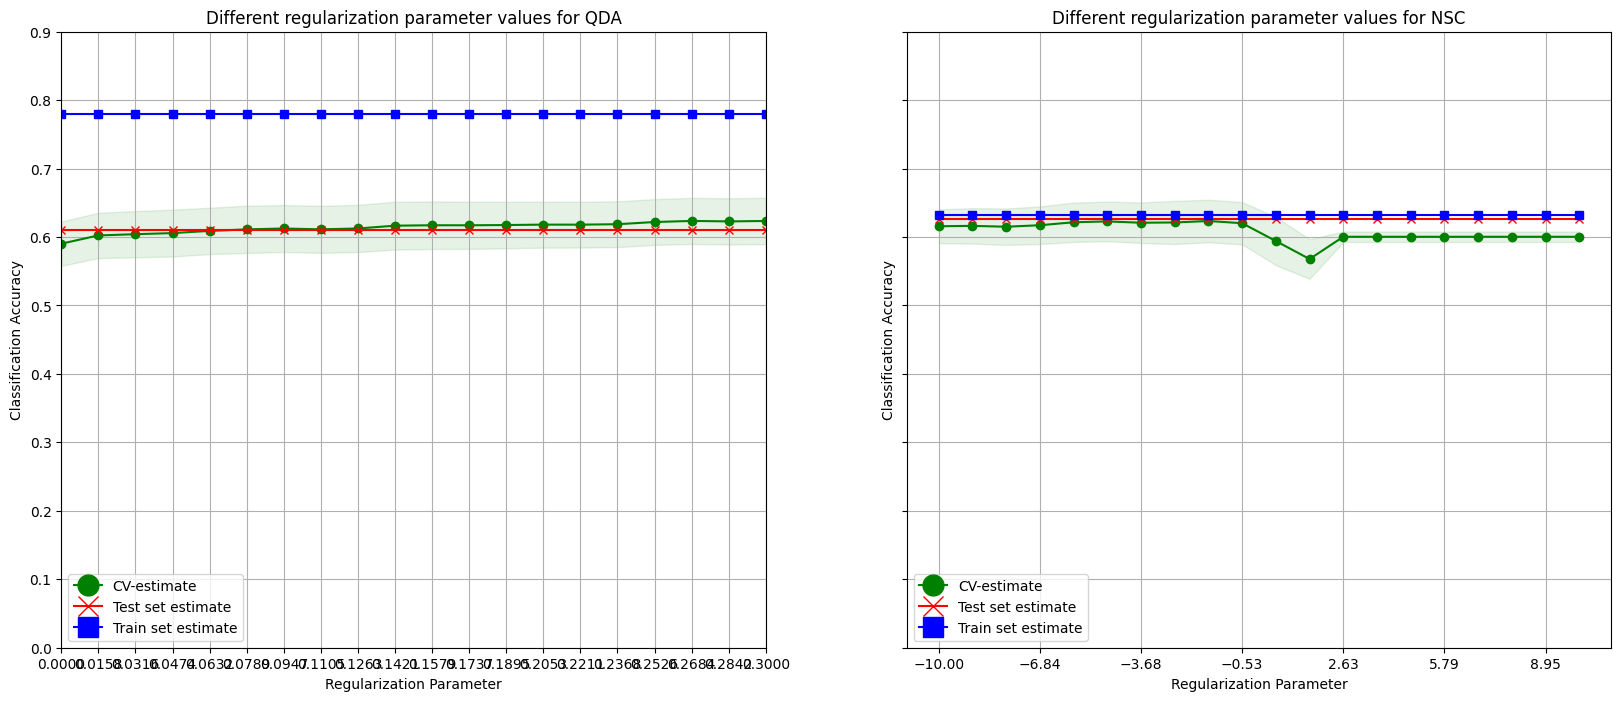

In [8]:

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(20,8))
line1, = axarr[0].plot(reg_param_values, accuracies1, 'o-', color="g")
line2, = axarr[0].plot(reg_param_values, test_accuracies/n, 'x-', color="r")
line3, = axarr[0].plot(reg_param_values, train_accuracies/n, 's-', color="b")
axarr[0].fill_between(reg_param_values, accuracies1 - std_accuracies1 / np.sqrt(10), \
    accuracies1 + std_accuracies1 / np.sqrt(10), alpha=0.1, color="g")
axarr[0].grid()
axarr[0].set_title("Different regularization parameter values for QDA")
axarr[0].set_xlabel('Regularization Parameter')
axarr[0].set_xticks(np.array(reg_param_values))
axarr[0].set_ylabel('Classification Accuracy')
axarr[0].set_ylim((0.0, 0.9))
axarr[0].set_xlim((0.0, .3))
legend_handles = [ mlines.Line2D([], [], color='g', marker='o', \
                          markersize=15, label='CV-estimate'), \
                mlines.Line2D([], [], color='r', marker='x', \
                          markersize=15, label='Test set estimate'),\
                mlines.Line2D([], [], color='b', marker='s', \
                          markersize=15, label='Train set estimate')]
axarr[0].legend(handles=legend_handles, loc = 3)


line1, = axarr[1].plot(shrinkage_param_values, accuracies_nsc1, 'o-', color="g")
line2, = axarr[1].plot(shrinkage_param_values, test_accuracies_nsc/n, 'x-', color="r")
line3, = axarr[1].plot(shrinkage_param_values, train_accuracies_nsc/n, 's-', color="b")
axarr[1].fill_between(shrinkage_param_values, accuracies_nsc1 - std_accuracies_nsc1 / np.sqrt(10), \
    accuracies_nsc1 + std_accuracies_nsc1 / np.sqrt(10), alpha=0.1, color="g")
axarr[1].grid()
axarr[1].set_title("Different regularization parameter values for NSC")
axarr[1].set_xlabel('Regularization Parameter')
axarr[1].set_xticks(shrinkage_param_values[ 0::3 ])
axarr[1].set_ylabel('Classification Accuracy')
axarr[1].set_ylim((0.0, 0.9))
legend_handles = [ mlines.Line2D([], [], color='g', marker='o', \
                          markersize=15, label='CV-estimate'), \
                mlines.Line2D([], [], color='r', marker='x', \
                          markersize=15, label='Test set estimate'),\
                mlines.Line2D([], [], color='b', marker='s', \
                          markersize=15, label='Train set estimate')]
axarr[1].legend(handles=legend_handles, loc = 3)

plt.show()

In [9]:
print(shrinkage_param_values[ np.argmax(accuracies_nsc1) ]) 

-1.578947368421053


In [10]:
print(reg_param_values[ np.argmax(accuracies1) ])

0.26842105263157895


## Fitting the Final Model and Estimating Its Performance
### Naive Bayes

In [11]:
conf =[0][0]
y_pred_b=[None]*n
for i in range(20):    
    nb = GaussianNB()
    nb.fit(X_train_b_scaled[i], y_train_b[i])
    y_pred_b[i] = nb.predict(X_test_b_scaled[i])

    conf = conf + confusion_matrix(y_test_b[i], y_pred_b[i])

    # The matrix conf contains:
    # TN | FN
    # FP | TP

    TN = conf[0][0]/n
    TP = conf[1][1]/n
    FP = conf[0][1]/n
    FN = conf[1][0]/n
    
pnb=((TP + TN) / (TN + TP + FP + FN))
print(conf/n)
print('Predicion accuracy is: %f' % ((TP + TN) / (TN + TP + FP + FN)))
print('True postive rate is: %f' % (TP / (TP + FN)))
print('True negative rate is: %f\n' % (TN / (TN + FP)))

[[31.75 10.4 ]
 [16.25  9.6 ]]
Predicion accuracy is: 0.608088
True postive rate is: 0.371373
True negative rate is: 0.753262



### Linear Discriminant

In [12]:
conf =[0][0]
y_pred_b=[None]*n

for i in range(20):   
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train_b_scaled[i], y_train_b[i])

    y_pred_b[i] = lda.predict(X_test_b_scaled[i])

    conf = conf + confusion_matrix(y_test_b[i], y_pred_b[i])

    # The matrix conf contains:
    # TN | FN
    # FP | TP

    TN = conf[0][0]/n
    TP = conf[1][1]/n
    FP = conf[0][1]/n
    FN = conf[1][0]/n

plda=((TP + TN) / (TN + TP + FP + FN))
print(conf/n)
print('Predicion accuracy is: %f' % ((TP + TN) / (TN + TP + FP + FN)))
print('True postive rate is: %f' % (TP / (TP + FN)))
print('True negative rate is: %f\n' % (TN / (TN + FP)))


[[30.3  11.85]
 [15.   10.85]]
Predicion accuracy is: 0.605147
True postive rate is: 0.419729
True negative rate is: 0.718861



### Quadratic Discriminant

In [13]:
conf =[0][0]
y_pred_b=[None]*n

for i in range(20):   
    qda = QuadraticDiscriminantAnalysis(reg_param = reg_param_values[ np.argmax(accuracies[i]) ])
    qda.fit(X_train_b_scaled[i], y_train_b[i])

    y_pred_b[i] = qda.predict(X_test_b_scaled[i])

    conf = conf + confusion_matrix(y_test_b[i], y_pred_b[i])

    # The matrix conf contains:
    # TN | FN
    # FP | TP

    TN = conf[0][0]/n
    TP = conf[1][1]/n
    FP = conf[0][1]/n
    FN = conf[1][0]/n

pqda=((TP + TN) / (TN + TP + FP + FN))
print(conf)
print('Predicion accuracy is: %f' % ((TP + TN) / (TN + TP + FP + FN)))
print('True postive rate is: %f' % (TP / (TP + FN)))
print('True negative rate is: %f\n' % (TN / (TN + FP)))

[[654 189]
 [344 173]]
Predicion accuracy is: 0.608088
True postive rate is: 0.334623
True negative rate is: 0.775801



### Nearest Crentroid


In [14]:
conf =[0][0]
y_pred_b=[None]*n

for i in range(20):   
    nsc = NearestCentroid(shrink_threshold = shrinkage_param_values[ np.argmax(accuracies_nsc[i]) ])
    nsc.fit(X_train_b_scaled[i], y_train_b[i])

    y_pred_b[i] = nsc.predict(X_test_b_scaled[i])

    conf = conf + confusion_matrix(y_test_b[i], y_pred_b[i])

    # The matrix conf contains:
    # TN | FN
    # FP | TP

    TN = conf[0][0]/n
    TP = conf[1][1]/n
    FP = conf[0][1]/n
    FN = conf[1][0]/n

pnsc=((TP + TN) / (TN + TP + FP + FN))
print(conf)
print('Predicion accuracy is: %f' % ((TP + TN) / (TN + TP + FP + FN)))
print('True postive rate is: %f' % (TP / (TP + FN)))
print('True negative rate is: %f\n' % (TN / (TN + FP)))

[[649 194]
 [348 169]]
Predicion accuracy is: 0.601471
True postive rate is: 0.326886
True negative rate is: 0.769870



## Plot comparativo

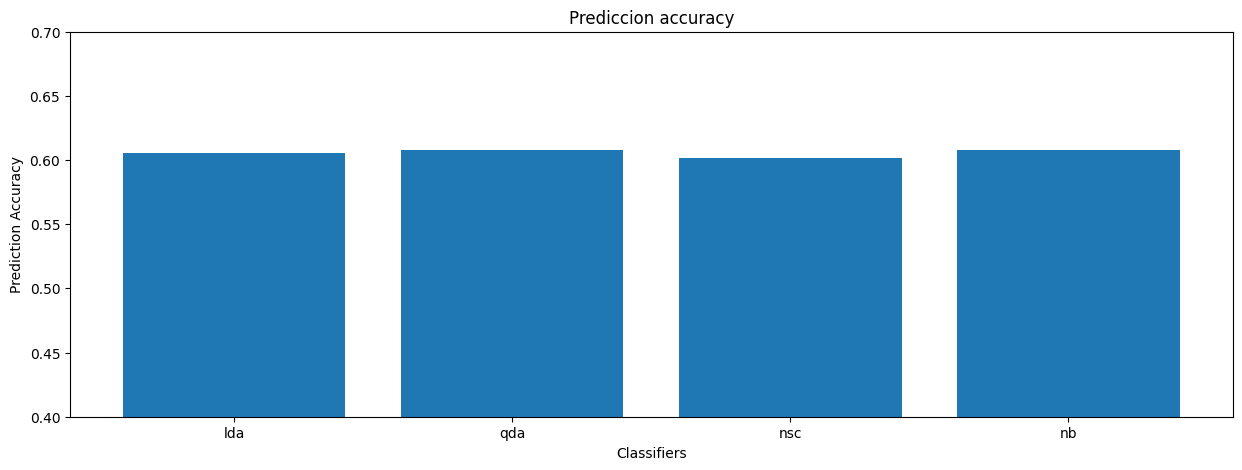

In [15]:
plt.bar(["lda", "qda", "nsc", "nb"],[plda, pqda, pnsc, pnb])
plt.ylim((0.4, 0.7))
plt.title("Prediccion accuracy")
plt.xlabel('Classifiers')
plt.ylabel('Prediction Accuracy')
plt.show()

## Plotting decision boundaries

In [16]:
def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='black',
                              linewidth=2, zorder=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


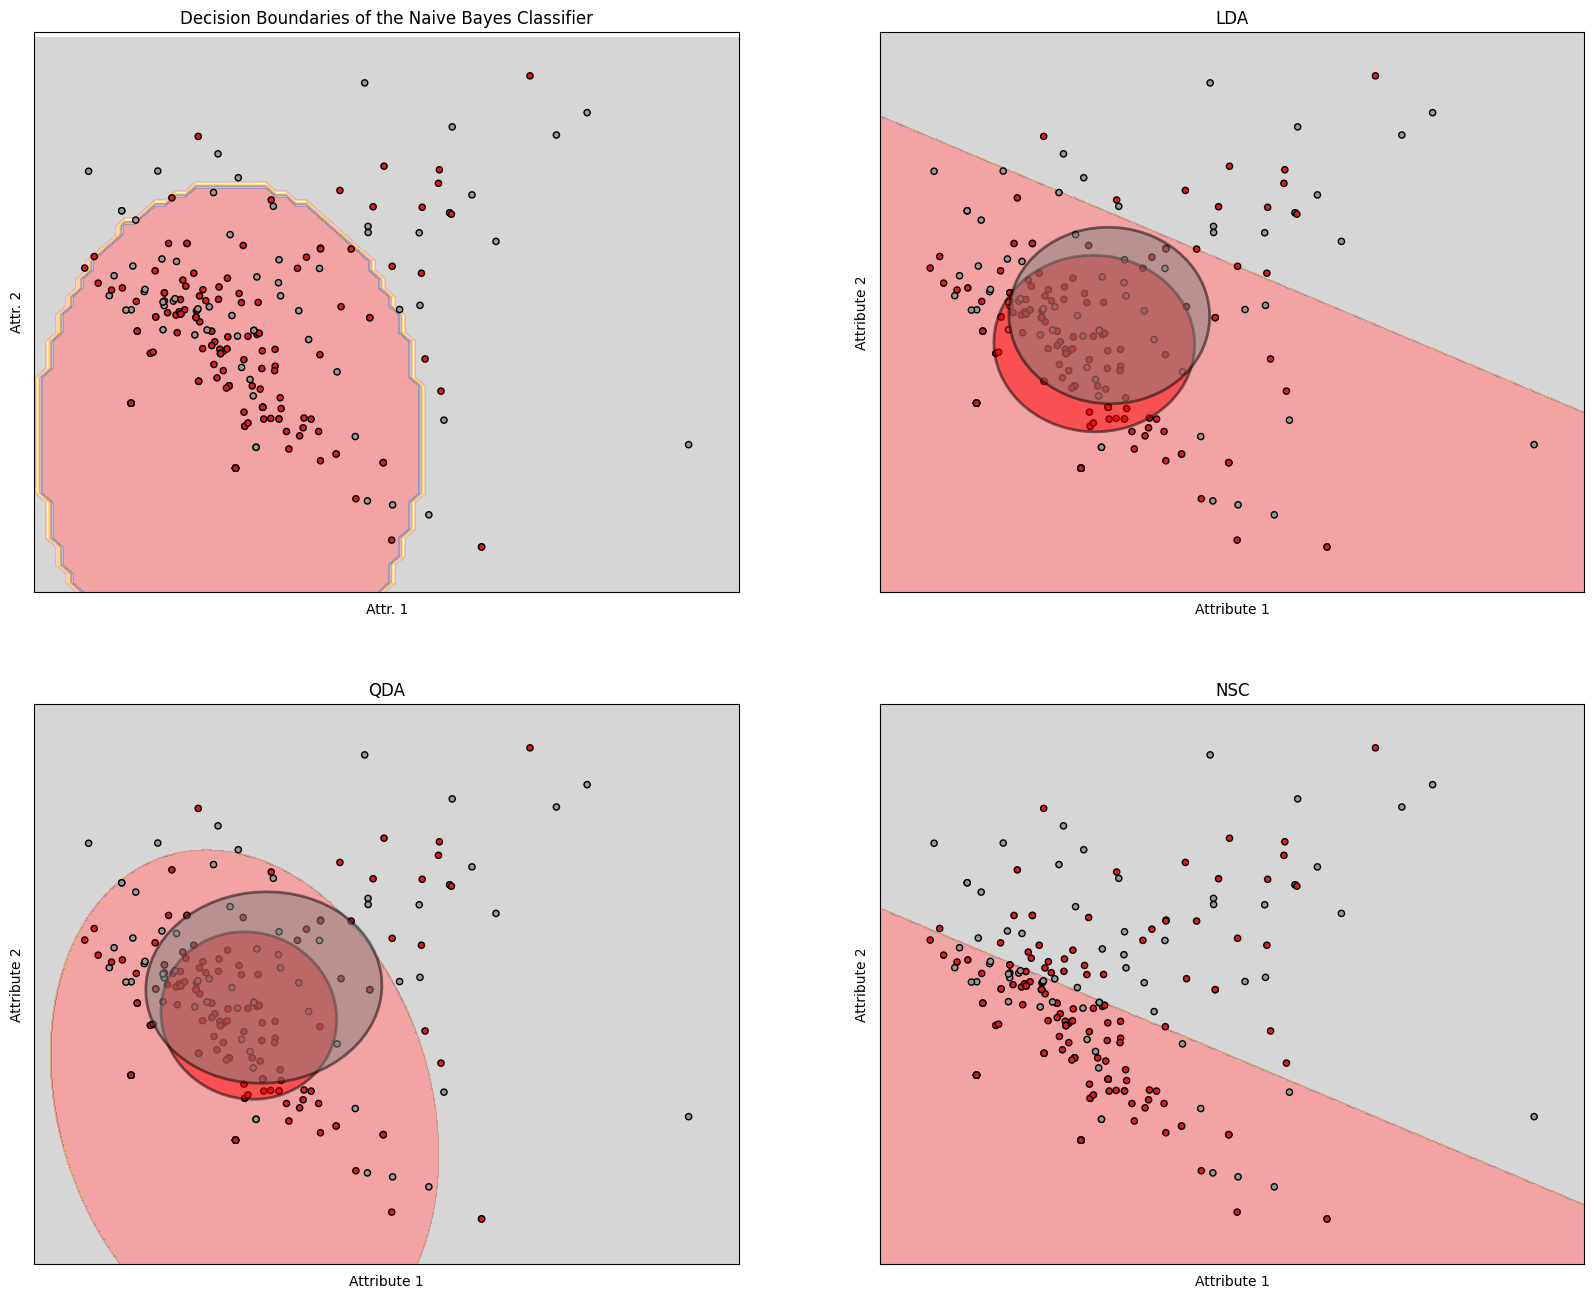

In [17]:
f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(20, 16))

X = np.array(X_b)[:, [0, 1]]
X_scaled = preprocessing.scale(X)
nb.fit(X_scaled, y_b)
x_min, x_max = X_scaled[:, 0].min() - .5, X_scaled[:, 0].max() + .5
y_min, y_max = X_scaled[:, 1].min() - .5, X_scaled[:, 1].max() + .5

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = nb.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[ 0,0 ].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axarr[ 0,0 ].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_b, s=20, edgecolor='k',\
        cmap=plt.cm.Set1)
axarr[ 0,0 ].set_title('Decision Boundaries of the Naive Bayes Classifier')
axarr[ 0,0 ].set_xlabel('Attr. 1')
axarr[ 0,0 ].set_ylabel('Attr. 2')



lda =  LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(X_scaled, y_b)

qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_scaled, y_b)

nsc = NearestCentroid()
nsc.fit(X_scaled, y_b)

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))



Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[0,1].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axarr[0,1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_b, s=20, edgecolor='k',\
    cmap=plt.cm.Set1)
axarr[0,1].set_title('LDA')
axarr[0,1].set_xlabel('Attribute 1')
axarr[0,1].set_ylabel('Attribute 2')

plot_ellipse(axarr[0,1], lda.means_[0], lda.covariance_, 'red')
plot_ellipse(axarr[0,1], lda.means_[1], lda.covariance_, 'gray')

Z = qda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[1,0].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axarr[1,0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_b, s=20, edgecolor='k',\
    cmap=plt.cm.Set1)
axarr[1,0].set_title('QDA')
axarr[1,0].set_xlabel('Attribute 1')
axarr[1,0].set_ylabel('Attribute 2')

plot_ellipse(axarr[1,0], qda.means_[0], qda.covariance_[0], 'red')
plot_ellipse(axarr[1,0], qda.means_[1], qda.covariance_[1], 'gray')


Z = nsc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[1,1].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axarr[1,1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_b, s=20, edgecolor='k',\
    cmap=plt.cm.Set1)
axarr[1,1].set_title('NSC')
axarr[1,1].set_xlabel('Attribute 1')
axarr[1,1].set_ylabel('Attribute 2')






plt.show()

In [76]:
y_en = np.array(df_aer['AER'])-11
X_tr, X_te, y_tr, y_te = train_test_split( \
        X_b, y_en, test_size=0.3, random_state=i)

In [77]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, lars_path, ElasticNet
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

alpha_vec = np.logspace(-2, 4)

from sklearn.linear_model import ElasticNetCV

gs_en = ElasticNetCV(l1_ratio=[.535, .7, .9, .95, .99, 1], cv=5, random_state=0)
gs_en.fit(X_te, y_te)

print("Best Regularization Parameter ElasticN: %.2g" % gs_en.alpha_)
print("Best Mixture Parameter ElasticN: %.2g" % gs_en.l1_ratio_)

gs_la = GridSearchCV(Lasso(max_iter=5000), cv=5, param_grid={"alpha": alpha_vec})
gs_la.fit(X_tr, y_tr)
print("Best Parameter Lasso: %.2g" % gs_la.best_params_["alpha"])

gs_rr = GridSearchCV(Ridge(), cv=5, param_grid={"alpha": alpha_vec})
gs_rr.fit(X_tr, y_tr)
print("Best Parameter Ridge: %.2g" % gs_rr.best_params_["alpha"])

Best Regularization Parameter ElasticN: 0.93
Best Mixture Parameter ElasticN: 0.54
Best Parameter Lasso: 0.91
Best Parameter Ridge: 2.6e+02


In [78]:
print("Ridge Regression: %.4f" % gs_rr.score(X_te, y_te))
print("Lasso:            %.4f" % gs_la.score(X_te, y_te))
print("Elastic-Net:      %.4f" % gs_en.score(X_te, y_te))

Ridge Regression: 0.0981
Lasso:            0.1355
Elastic-Net:      0.3242


Ridge Regression MSE: 238.5127
Lasso MSE:            228.6195
Elastic-Net MSE:      178.7336


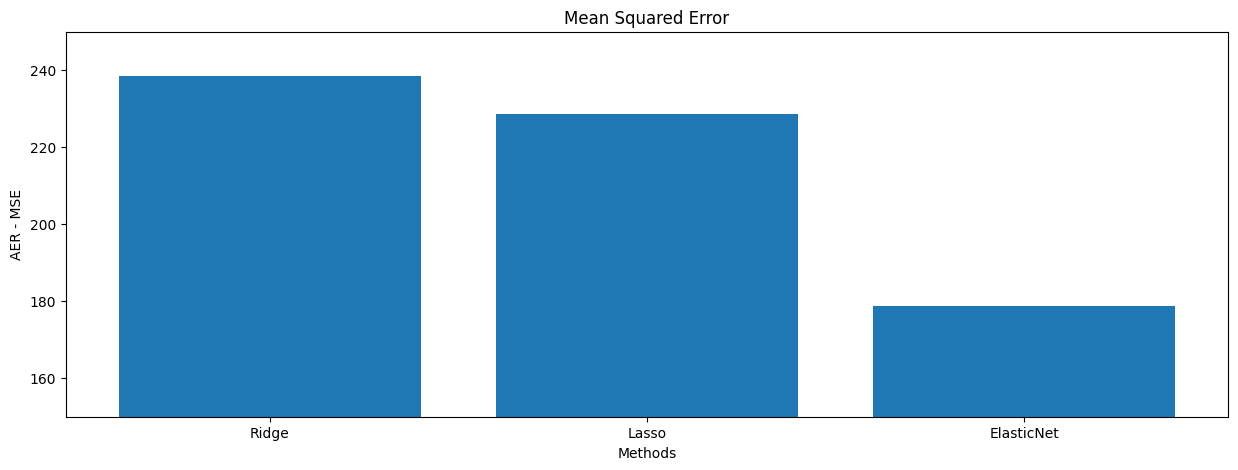

In [79]:
ridge_error = mean_squared_error(y_te, gs_rr.predict(X_te))
lasso_error = mean_squared_error(y_te, gs_la.predict(X_te))
elastic_error = mean_squared_error(y_te, gs_en.predict(X_te))
plt.bar(["Ridge", "Lasso", "ElasticNet"],[ridge_error, lasso_error, elastic_error])
plt.ylim((150, 250))
plt.title("Mean Squared Error")
plt.xlabel('Methods')
plt.ylabel('AER - MSE')

print("Ridge Regression MSE: %.4f" % ridge_error)
print("Lasso MSE:            %.4f" % lasso_error)
print("Elastic-Net MSE:      %.4f" % elastic_error)

plt.show()


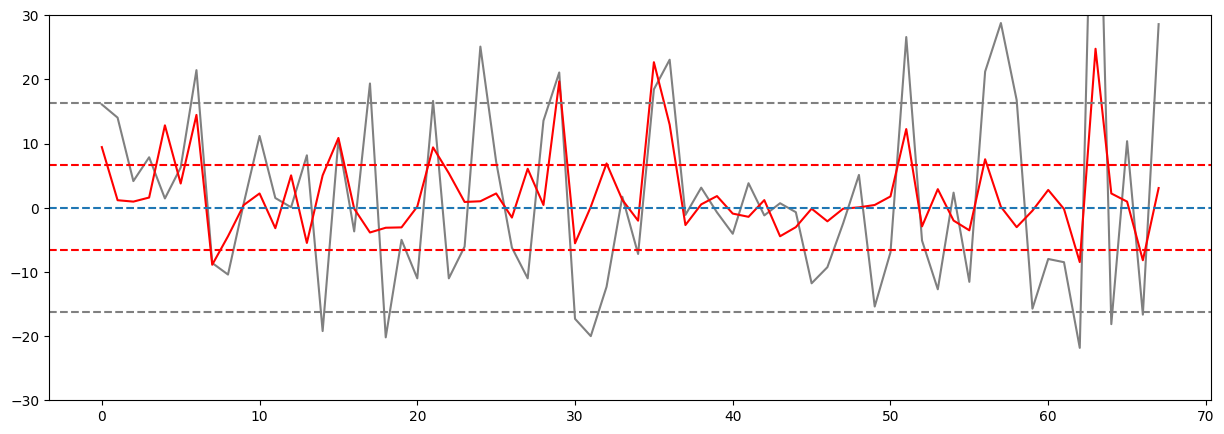

In [86]:
#plt.plot(range(len(y_te)), np.sqrt((y_te - y_pred)**2))

y_pred = gs_en.predict(X_te)
#y_pred = np.array(y_pred)*2.2
plt.plot(range(len(y_te)),y_te, color='grey')
plt.plot(range(len(y_te)),y_pred, color='red')
plt.ylim(-30, 30)
plt.axhline(y=0, linestyle="dashed")
plt.axhline(y=-np.array(y_te).std(), linestyle="dashed", color='grey')
plt.axhline(y=+np.array(y_te).std(), linestyle="dashed", color='grey')
plt.axhline(y=-np.array(y_pred).std(), linestyle="dashed", color='red')
plt.axhline(y=+np.array(y_pred).std(), linestyle="dashed", color='red')


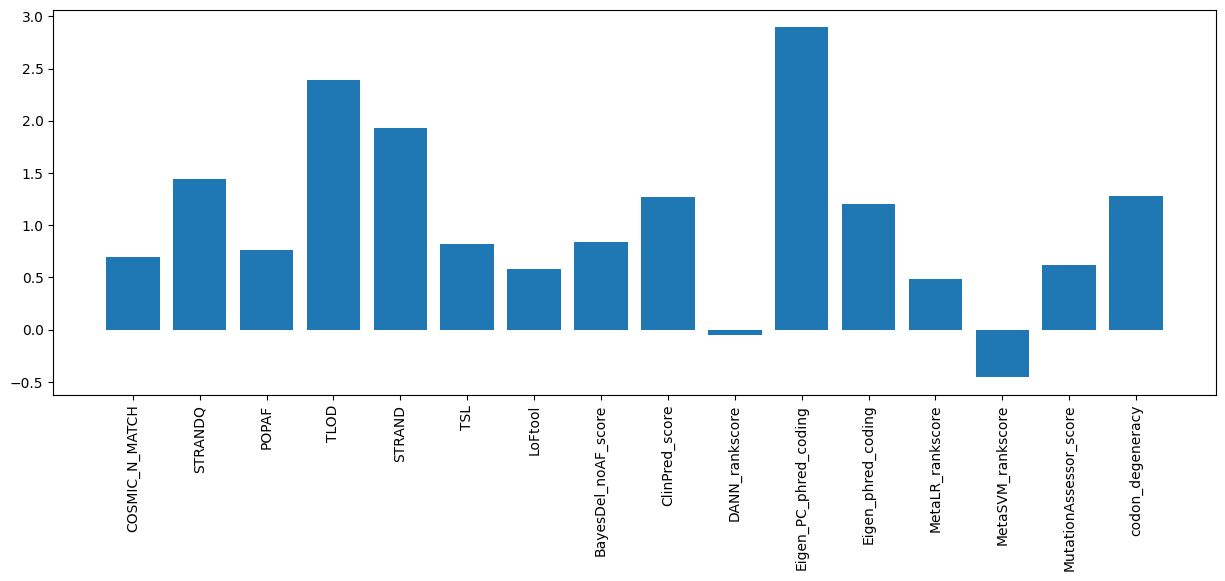

In [23]:
coefs = gs_en.coef_!=0


plt.bar(np.array(numeric_columns)[coefs], gs_en.coef_[coefs])
plt.xticks(rotation=90)
plt.show()

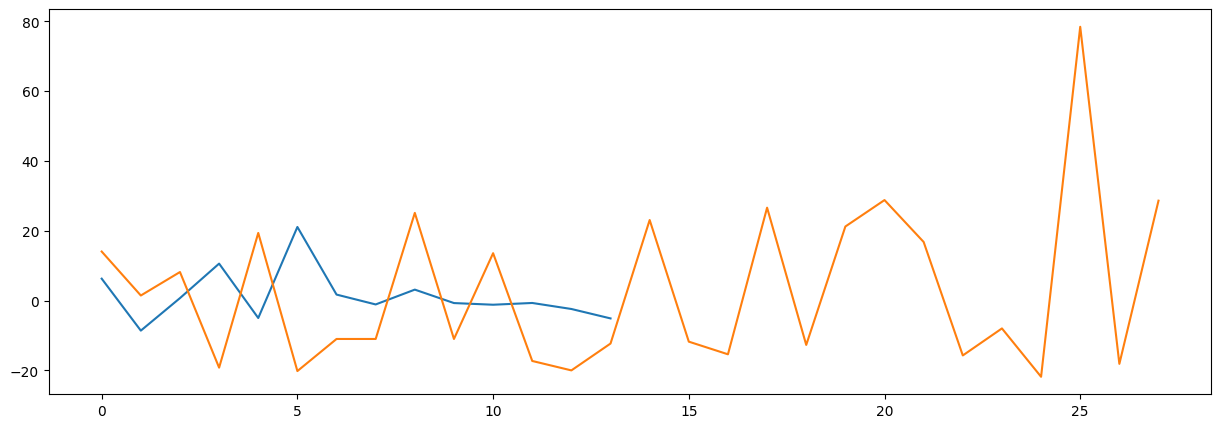

In [49]:
y_binar_less_error = np.sqrt((y_te - y_pred)**2)<3
less = np.array(y_te)[y_binar_less_error]
y_binar_more_error = np.sqrt((y_te - y_pred)**2)>10
more = np.array(y_te)[y_binar_more_error]

plt.plot(range(len(less)), less)
plt.plot(range(len(more)), more)

In [52]:

y_p2 = []
for value in y_pred:
    if value>=0:
        y_p2.append(1)
    else:
        y_p2.append(0)
y_te2 =[] 

for value in y_te:
    if value>=0:
        y_te2.append(1)
    else:
        y_te2.append(0)
        
        


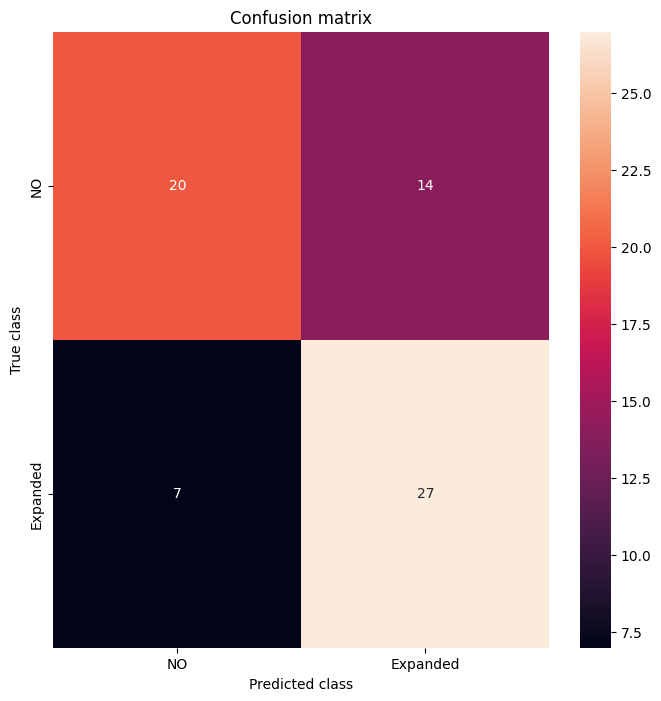

              precision    recall  f1-score   support

           0       0.74      0.59      0.66        34
           1       0.66      0.79      0.72        34

    accuracy                           0.69        68
   macro avg       0.70      0.69      0.69        68
weighted avg       0.70      0.69      0.69        68



In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
LABELS = ["NO", "Expanded"]
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))
mostrar_resultados(y_te2, y_p2)

## Ridge alpha

In [54]:

mse_tr = np.zeros(len(alpha_vec))
mse_te = np.zeros(len(alpha_vec))
coefs = np.zeros((len(alpha_vec), X_tr.shape[1]))
for i_alp in range(len(alpha_vec)):
    model = Ridge(alpha_vec[i_alp])
    model.fit(X_tr, y_tr)
    mse_tr[i_alp] = mean_squared_error(y_tr, model.predict(X_tr))
    mse_te[i_alp] = mean_squared_error(y_te, model.predict(X_te))
    coefs[i_alp, :] = model.coef_

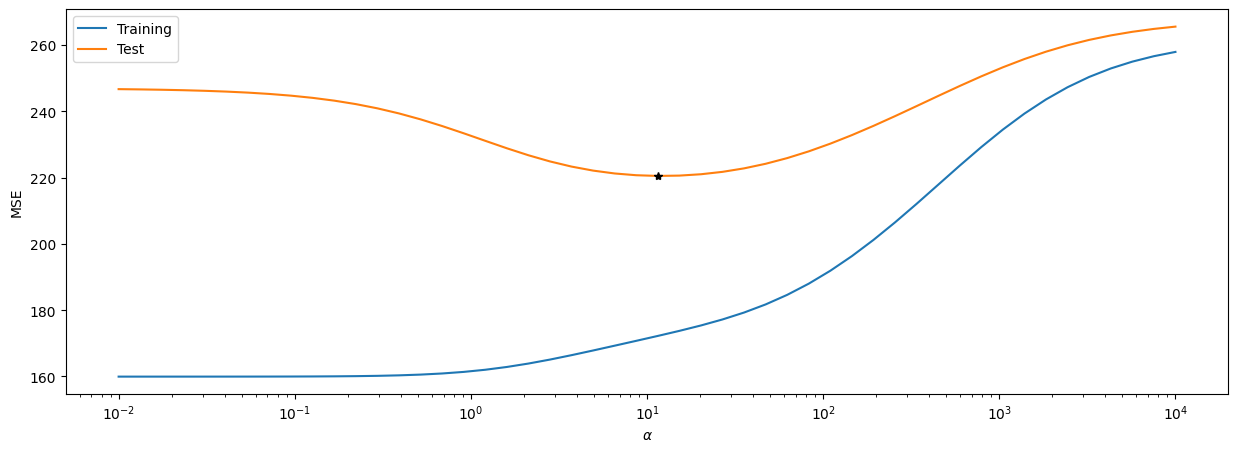

11.513953993264469

In [55]:
plt.semilogx(alpha_vec, mse_tr, label="Training")
plt.semilogx(alpha_vec, mse_te, label="Test")

i_opt = np.argmin(mse_te)
plt.semilogx(alpha_vec[i_opt], mse_te[i_opt], "k*")

plt.xlabel("$\\alpha$")
plt.ylabel("MSE")
plt.legend()
plt.show()
mse_ridge = mse_te[i_opt]
alpha_vec[i_opt]

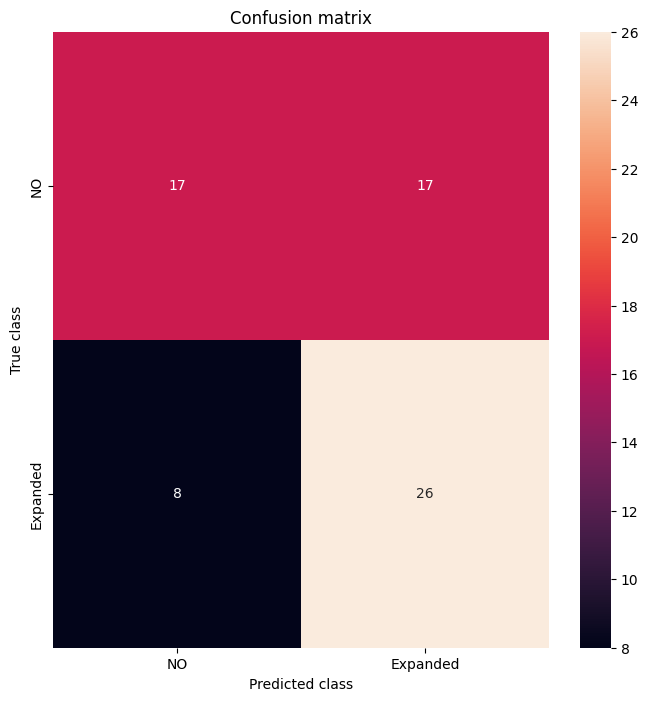

              precision    recall  f1-score   support

           0       0.68      0.50      0.58        34
           1       0.60      0.76      0.68        34

    accuracy                           0.63        68
   macro avg       0.64      0.63      0.63        68
weighted avg       0.64      0.63      0.63        68



In [56]:
model = Ridge(alpha_vec[i_opt])
model.fit(X_tr, y_tr)
y_pred = model.predict(X_te)
y_p2 = []
for value in y_pred:
    if value>=0:
        y_p2.append(1)
    else:
        y_p2.append(0)
y_te2 =[] 

for value in y_te:
    if value>=0:
        y_te2.append(1)
    else:
        y_te2.append(0)

mostrar_resultados(y_te2, y_p2)

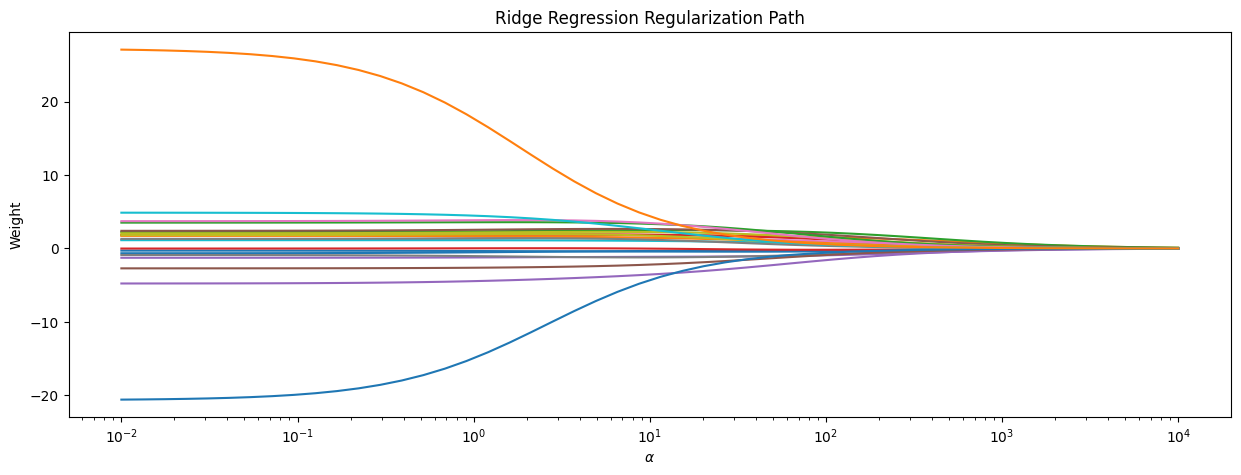

In [57]:
plt.semilogx(alpha_vec, coefs)

plt.title("Ridge Regression Regularization Path")
plt.xlabel("$\\alpha$")
plt.ylabel("Weight")
plt.show()

## Lasso alpha

In [58]:
mse_tr = np.zeros(len(alpha_vec))
mse_te = np.zeros(len(alpha_vec))
coefs = np.zeros((len(alpha_vec), X_tr.shape[1]))
for i_alp in range(len(alpha_vec)):
    model = Lasso(alpha_vec[i_alp], max_iter=5000)
    model.fit(X_tr, y_tr)
    mse_tr[i_alp] = mean_squared_error(y_tr, model.predict(X_tr))
    mse_te[i_alp] = mean_squared_error(y_te, model.predict(X_te))
    coefs[i_alp, :] = model.coef_

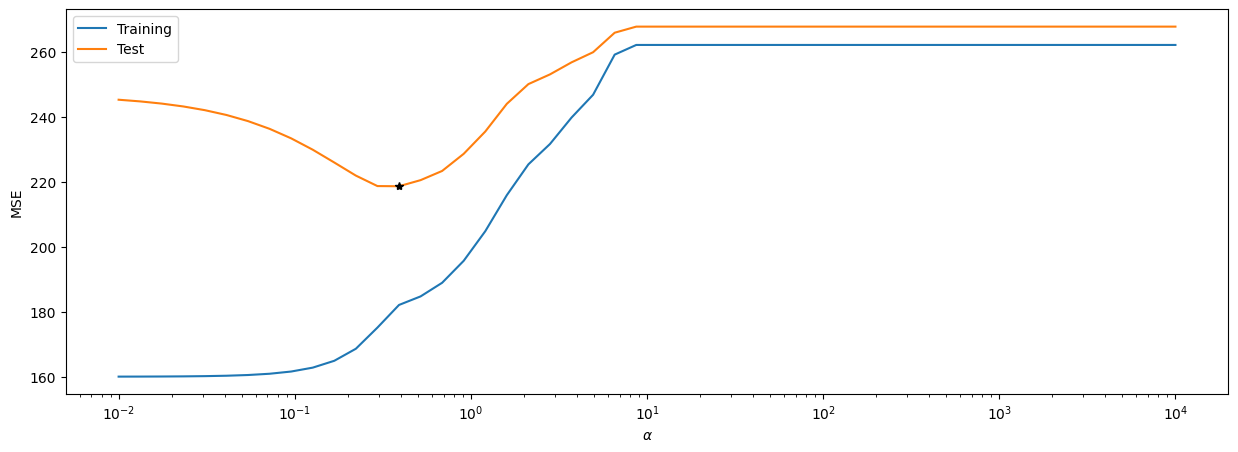

0.3906939937054617

In [59]:
plt.semilogx(alpha_vec, mse_tr, label="Training")
plt.semilogx(alpha_vec, mse_te, label="Test")

i_opt = np.argmin(mse_te)
plt.semilogx(alpha_vec[i_opt], mse_te[i_opt], "k*")

plt.xlabel("$\\alpha$")
plt.ylabel("MSE")
plt.legend()
plt.show()
mse_lasso = mse_te[i_opt]
alpha_vec[i_opt]

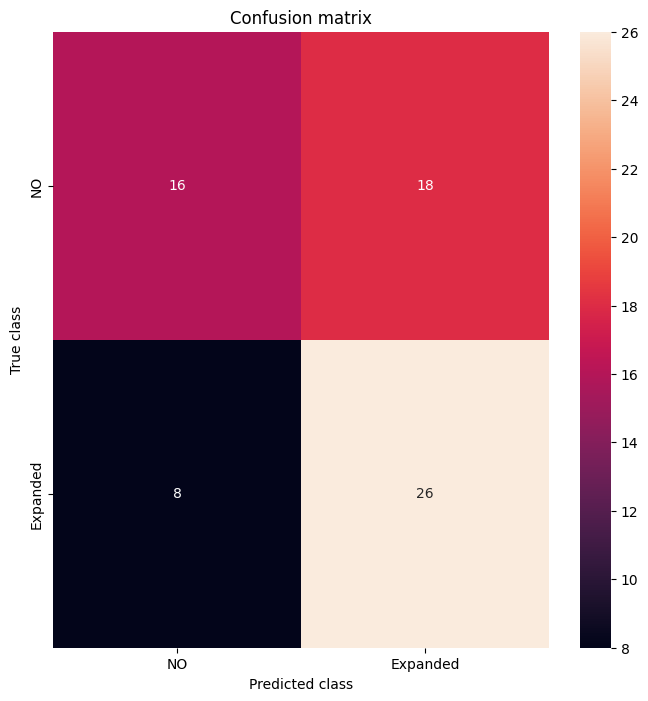

              precision    recall  f1-score   support

           0       0.67      0.47      0.55        34
           1       0.59      0.76      0.67        34

    accuracy                           0.62        68
   macro avg       0.63      0.62      0.61        68
weighted avg       0.63      0.62      0.61        68



In [60]:
model = Lasso(alpha_vec[i_opt], max_iter=5000)
model.fit(X_tr, y_tr)
y_pred = model.predict(X_te)
y_p2 = []
for value in y_pred:
    if value>=0:
        y_p2.append(1)
    else:
        y_p2.append(0)
y_te2 =[] 

for value in y_te:
    if value>=0:
        y_te2.append(1)
    else:
        y_te2.append(0)

mostrar_resultados(y_te2, y_p2)

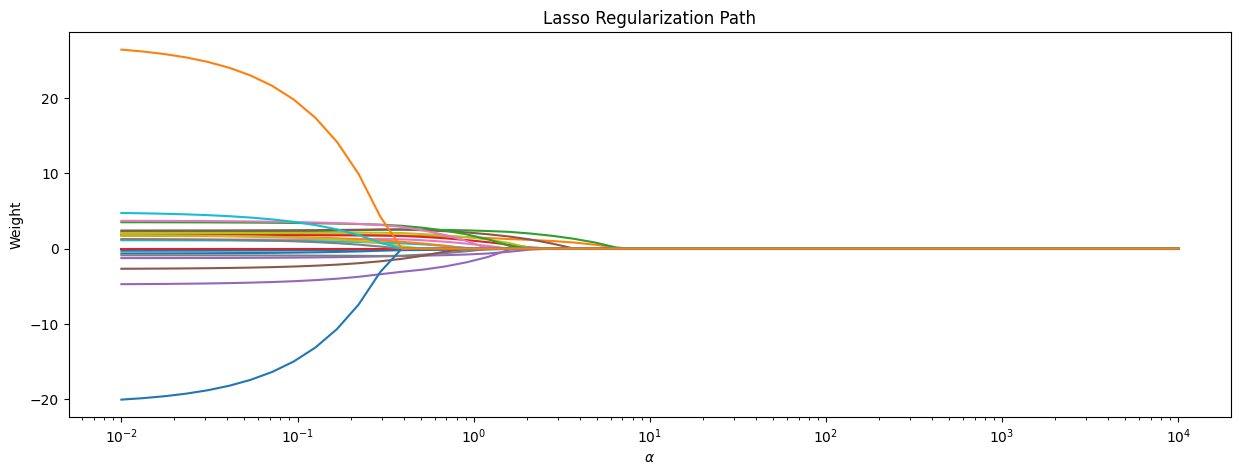

In [61]:
plt.semilogx(alpha_vec, coefs)

plt.title("Lasso Regularization Path")
plt.xlabel("$\\alpha$")
plt.ylabel("Weight")
plt.show()

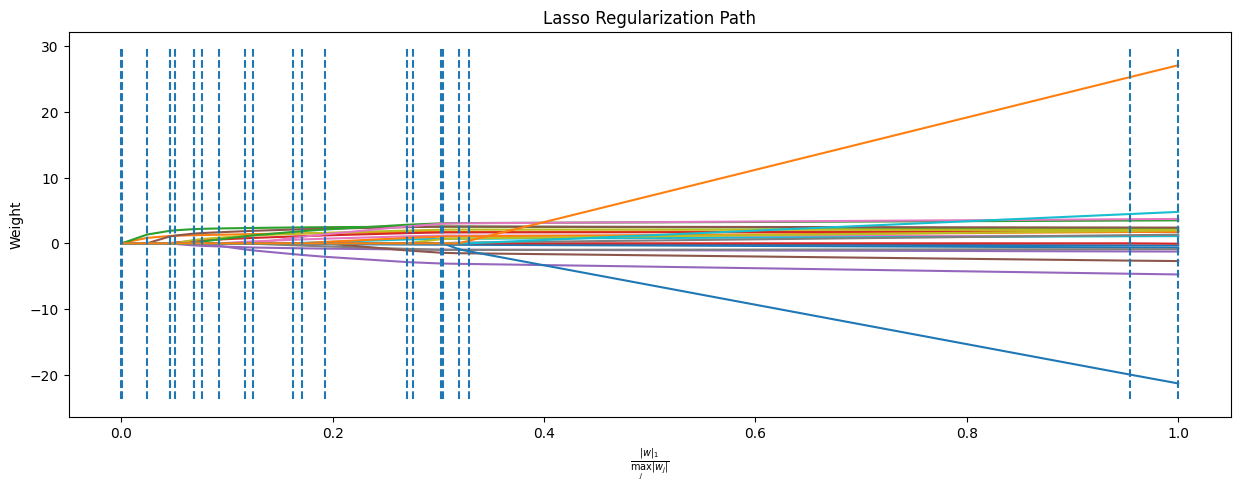

In [62]:
y_tr = np.array(y_tr)
_, _, coefs = lars_path(X_tr, y_tr, method="lasso")

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle="dashed")

plt.title("Lasso Regularization Path")
plt.xlabel("$\\frac{\\|w\\|_1}{\\max_j\\|w_j\\|}$")
plt.ylabel("Weight")
plt.axis("tight")
plt.show()

In [63]:
print(mse_ridge, mse_lasso)

220.48086896590007 218.62992886193243


In [64]:
from sklearn.linear_model import ElasticNetCV
regr = ElasticNetCV(l1_ratio=[.5, .7, .9, .95, .99, 1], cv=5, random_state=0)
regr.fit(X_te, y_te)

print(regr.alpha_, regr.l1_ratio_, regr.score(X_te, y_te))


0.9999824922415488 0.5 0.3171075190607523


In [65]:
elastic_error = mean_squared_error(y_te, regr.predict(X_te))
elastic_error

180.59826514739586

In [66]:
y_en = df_aer['DRIVER'].astype(int)
X_tr, X_te, y_tr, y_te = train_test_split( \
        X_b, y_en, test_size=0.3, random_state=i)

RF


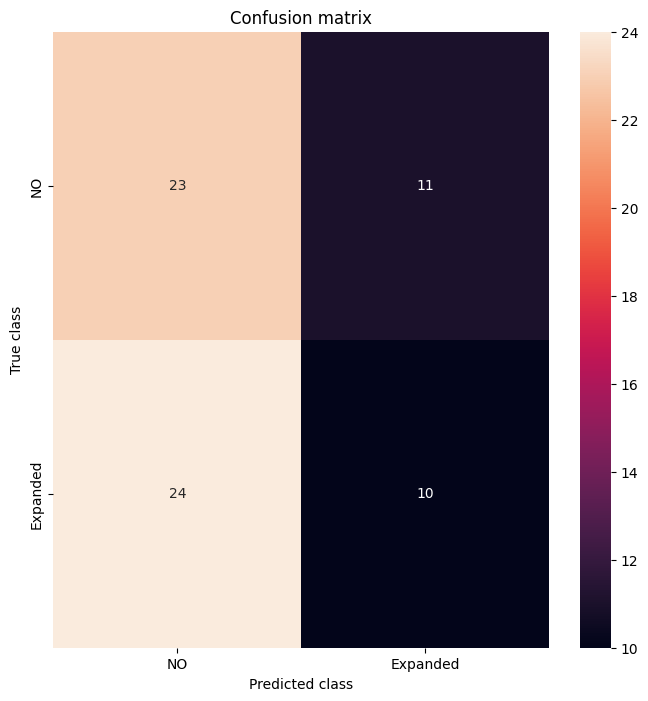

              precision    recall  f1-score   support

           0       0.49      0.68      0.57        34
           1       0.48      0.29      0.36        34

    accuracy                           0.49        68
   macro avg       0.48      0.49      0.47        68
weighted avg       0.48      0.49      0.47        68



In [67]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier( class_weight='balanced')


#The pipeline is created.
pipelineRF = Pipeline([("RF", RF)])

gsRF1 = GridSearchCV(pipelineRF, cv=5,
                  param_grid={"RF__ccp_alpha": np.logspace(-5, 5),
                             "RF__max_depth": [10],
                             "RF__n_estimators": [10, 15, 20, 22, 23]})

gsRF1.fit(X_tr, y_tr)
y_pred = gsRF1.predict(X_te)
print('RF')
mostrar_resultados(y_te, y_pred)


In [68]:
gsRF1.best_params_

{'RF__ccp_alpha': 0.0006866488450042998,
 'RF__max_depth': 10,
 'RF__n_estimators': 23}

In [69]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(class_weight="balanced")
#The pipeline is created.
pipeline = Pipeline([("LR", LR)])

gs1 = GridSearchCV(pipeline, cv=5,
                  param_grid={"LR__l1_ratio": np.logspace(-10, 10, 10),
                              "LR__C": np.logspace(-10, 10, 10),
                              "LR__fit_intercept": [True, False]})

gs1.fit(X_tr, y_tr)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('LR',
                                        LogisticRegression(class_weight='balanced'))]),
             param_grid={'LR__C': array([1.00000000e-10, 1.66810054e-08, 2.78255940e-06, 4.64158883e-04,
       7.74263683e-02, 1.29154967e+01, 2.15443469e+03, 3.59381366e+05,
       5.99484250e+07, 1.00000000e+10]),
                         'LR__fit_intercept': [True, False],
                         'LR__l1_ratio': array([1.00000000e-10, 1.66810054e-08, 2.78255940e-06, 4.64158883e-04,
       7.74263683e-02, 1.29154967e+01, 2.15443469e+03, 3.59381366e+05,
       5.99484250e+07, 1.00000000e+10])})

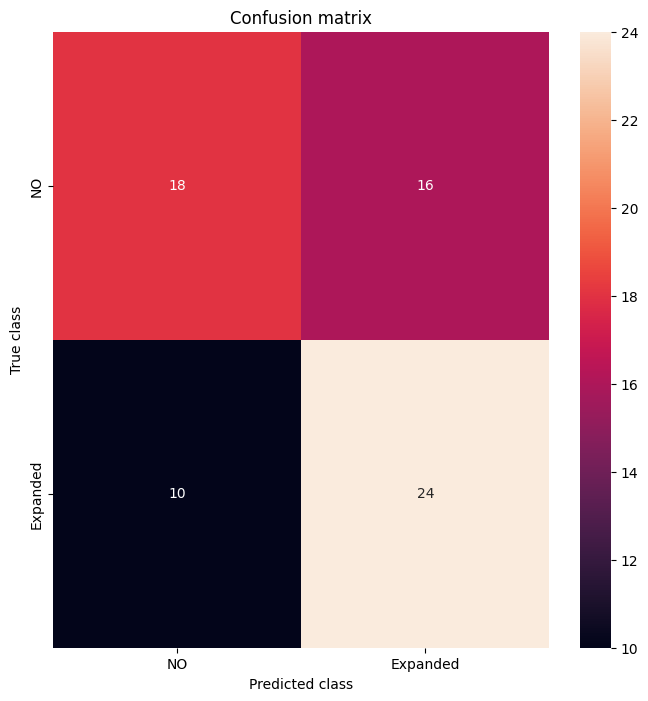

              precision    recall  f1-score   support

           0       0.64      0.53      0.58        34
           1       0.60      0.71      0.65        34

    accuracy                           0.62        68
   macro avg       0.62      0.62      0.61        68
weighted avg       0.62      0.62      0.61        68



{'LR__C': 0.07742636826811278,
 'LR__fit_intercept': True,
 'LR__l1_ratio': 1e-10}

In [70]:
y_pred = gs1.predict(X_te)
mostrar_resultados(y_te, y_pred)
gs1.best_params_